# Análise exploratória de dados

In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

## 1. Descrição dos dados

In [2]:
db = pd.read_csv('../data/raw/data.csv', delimiter=";")
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id          100000 non-null  int64 
 1   tweet_text  100000 non-null  object
 2   tweet_date  100000 non-null  object
 3   sentiment   100000 non-null  int64 
 4   query_used  100000 non-null  object
dtypes: int64(2), object(3)
memory usage: 3.8+ MB


Analisando a nossa base de dados, podemos notar que ela possui $1 \times 10^5$ instâncias e 5 colunas, 3 destas possuindo variáveis discretas e 2 destas possuindo variáveis qualitativas.

In [3]:
db.isnull().sum()

id            0
tweet_text    0
tweet_date    0
sentiment     0
query_used    0
dtype: int64

Podemos verificar que nossa base de dados não possui valores nulos. Mostremos uma amostra dela abaixo:

In [4]:
db.head()

,id,tweet_text,tweet_date,sentiment,query_used
0,1050785521201541121,@Laranjito76 A pessoa certa para isso seria o ...,Fri Oct 12 16:29:25 +0000 2018,1,:)
1,1050785431955140608,"@behin_d_curtain Para mim, é precisamente o co...",Fri Oct 12 16:29:04 +0000 2018,1,:)
2,1050785401248645120,Vou fazer um video hoje... estou pensando em f...,Fri Oct 12 16:28:56 +0000 2018,1,:)
3,1050785370982547461,"aaaaaaaa amei tanto essas polaroids, nem sei e...",Fri Oct 12 16:28:49 +0000 2018,1,:)
4,1050785368902131713,Valoriza o coração do menininho que vc tem. El...,Fri Oct 12 16:28:49 +0000 2018,1,:)


### 1.1. Descrição das variáveis

In [5]:
dic = pd.read_csv('../data/external/dicionario.csv')
dic

,variavel,significado,tipo
id,ID único por usuário,nominal,NaN
tweet_text,Texto publicado,nominal,NaN
tweet_date,Data de publicação,nominal,NaN
sentiment,Algorítmo de classificação do sentimento do us...,nominal,"[0,1,2]"
query_used,Palavra relevante,nominal,"[':)', ':(', 'veja', 'jornaloglobo', 'g1', 'fo..."


Podemos analisar questões estatísticas da nossa base de dados usando o seguinte comando:

In [6]:
db.describe()

,id,sentiment
count,1.000000e+05,100000.000000
mean,1.045736e+18,1.000000
std,4.262747e+15,0.816497
min,1.027374e+18,0.000000
25%,1.045369e+18,0.000000
50%,1.046820e+18,1.000000
75%,1.049106e+18,2.000000
max,1.053355e+18,2.000000


### 1.2. Obtenção de período do dia

In [7]:
db['date'] = pd.to_datetime(db['tweet_date'])

In [8]:
db['period'] = (db['date'].dt.hour % 24 + 4) // 4
db['period'].replace({1: 'Late Night',
                      2: 'Early Morning',
                      3: 'Morning',
                      4: 'Noon',
                      5: 'Evening',
                      6: 'Night'}, inplace=True)
db['sentiment'].replace({0: 'Negative',
                         1: 'Positive',
                         2: 'Neutral'}, inplace=True)
db.head()

,id,tweet_text,tweet_date,sentiment,query_used,date,period
0,1050785521201541121,@Laranjito76 A pessoa certa para isso seria o ...,Fri Oct 12 16:29:25 +0000 2018,Positive,:),2018-10-12 16:29:25+00:00,Evening
1,1050785431955140608,"@behin_d_curtain Para mim, é precisamente o co...",Fri Oct 12 16:29:04 +0000 2018,Positive,:),2018-10-12 16:29:04+00:00,Evening
2,1050785401248645120,Vou fazer um video hoje... estou pensando em f...,Fri Oct 12 16:28:56 +0000 2018,Positive,:),2018-10-12 16:28:56+00:00,Evening
3,1050785370982547461,"aaaaaaaa amei tanto essas polaroids, nem sei e...",Fri Oct 12 16:28:49 +0000 2018,Positive,:),2018-10-12 16:28:49+00:00,Evening
4,1050785368902131713,Valoriza o coração do menininho que vc tem. El...,Fri Oct 12 16:28:49 +0000 2018,Positive,:),2018-10-12 16:28:49+00:00,Evening


### 1.3. Quantidade de tweets por período

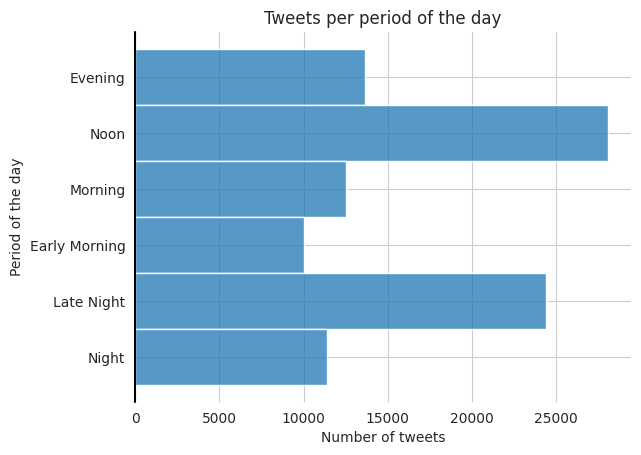

In [9]:
sns.set_style('whitegrid')
axis = sns.histplot(data=db, y='period')
axis.set(frame_on=False)
axis.axvline(0, color='k', clip_on=False)
plt.ylabel('Period of the day')
plt.xlabel('Number of tweets')
plt.title('Tweets per period of the day')
plt.show()

Como podemos perceber, a maior parte dos tweets se concentram no período da tarde e durante a madrugada. Veremos agora a relação entre os tweets positivos, negativos e neutros durante o período a partir do gráfico a seguir:

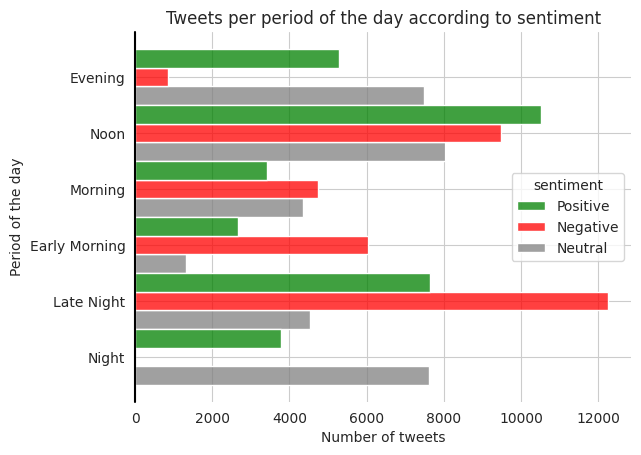

In [9]:
sns.set_style('whitegrid')
axis = sns.histplot(data=db, y='period', hue='sentiment', bins=5,
                   palette={'Negative': 'red', 'Neutral': 'gray' , 'Positive': 'green'},
                   multiple='dodge')
axis.set(frame_on=False)
axis.axvline(0, color='k', clip_on=False)
plt.ylabel('Period of the day')
plt.xlabel('Number of tweets')
plt.title('Tweets per period of the day according to sentiment')
plt.show()

Observamos que durante a madrugada a maior parte dos tweets tendem a ser negativos, durante o meio-dia os positivos estão ligeiramente à frente dos negativos e durante o período noturno tweets negativos são inexistentes, sendo em sua maioria neutros.

## 2. Perguntas de partida e hipóteses

Podemos fazer os seguintes questionamentos:
   1. Por que alguns períodos do dia tem mais tweets do que outros?
   
   2. Qual a correlação entre o tipo de sentimento e o período do dia?
   
   3. O conteúdo do tweet é relevante para a avaliação do sentimento?
    
Levantei as seguintes hipóteses sobre os questionamentos:
  1. A disponibilidade das pessoas para postar varia de acordo com seu tempo livre, no final da tarde o fim do expediente proporciona mais tempo livre para a população, bem como o fim da noite pode ser mais confortável para escrever sem se preocupar com afazeres posteriores.
  
  2. Ao acordar, muitas pessoas estão com pouca disposição e precisam lidar com a espectativa de iniciar algum tipo de trabalho ou atividade análoga, causando uma maioria de sentimentos negativos e neutros. Durante a tarde, metade do dia se foi e os sentimentos positivos acabam por aumentar e durante a noite acabam por desaparecer por conta do encerramento das atividades. Durante a madrugada vemos uma maioria esmagadora de sentimentos negativos tendo em vista que uma parcela minoritária da população se encontra acordada nesse horário, e estas muito provavelmente devem sofrer de insônia e doenças relacionadas que acabam causando sentimentos negativos nas mesmas.
  
  3. O conteúdo pode não ter muita relação, mas a palavra-chave utilizada pelo nosso banco de dados acaba por nos mostrar uma tendência sentimental em relação ao conteúdo dos tweets que a utilizam.

## 3. Insights

Como constatado pelos gráficos, quando verificamos os períodos de fim de tarde e noturno, é possível notar que os sentimentos negativos acabam por diminuirem progressivamente até praticamente inexistirem até altas horas da noite.

Esse banco de dados pode ser útil para detectar que tipo de usuário pode estar sofrendo com problemas de sono e estresse. É possível notar que ao explorar este banco de dados não somente temos informações do dia-a-dia dos usuários de forma implícita como também podemos ter informações valiosas sobre eles, podendo direcionar conteúdo de propaganda que seja relevante para eles naquele momento do seu dia.